* **Bài toán nhóm cần giải quyết là dự đoán `humidity` của ngày hôm sau dựa vào dữ liệu của các ngày hôm trước**  
* **Mô hình nhóm chọn là: `Linear Regression`, `Support Vector Regression`, `MLPRegressor`**  
* **Phương pháp đánh giá nhóm chọn là: `mean_absolute_error`**

## 1. Import các thư viện cần thiết

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

## 2. Load data

In [2]:
data_df = pd.read_csv('Data/weather.csv')
data_df.head()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,visibility
0,1262304000,73.45,75.07,72.69,0.97,1010.3,6.72,71.0,0.50,0.0,NaN
1,1262390400,71.67,72.95,69.81,0.94,1011.0,2.29,41.0,0.44,0.0,4.974
2,1262476800,75.25,76.89,73.39,0.94,1011.6,1.16,30.0,0.75,0.0,4.346
3,1262563200,75.25,76.64,71.61,0.88,1010.9,3.46,71.0,0.75,0.0,6.216
4,1262649600,75.25,76.89,73.39,0.94,1010.1,6.91,120.0,0.44,0.0,6.216


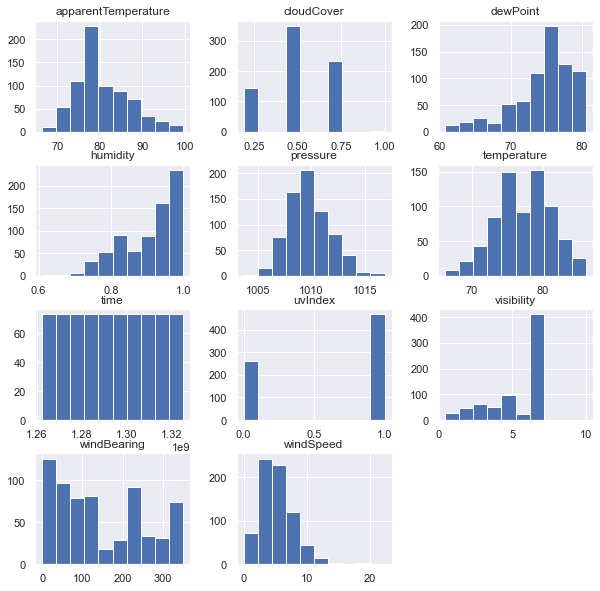

In [3]:
sns.set()
data_df.hist(figsize=(10,10))
plt.show()

**Visualize cột humidity**

In [4]:
data_df.humidity.describe()

count    730.000000
mean       0.911233
std        0.083330
min        0.610000
25%        0.840000
50%        0.940000
75%        1.000000
max        1.000000
Name: humidity, dtype: float64

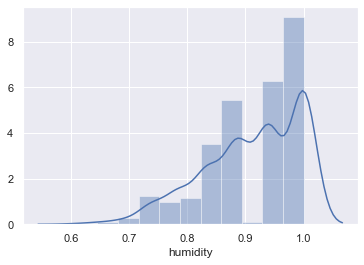

In [5]:
sns.distplot(data_df.humidity)

## 3. Tách data thành ba tập train, test và validation với tỉ lệ 6:2:2



In [6]:
# Lấy output và chỉ lấy 729 phần tử sau
y_data = data_df["humidity"].copy()
y_data = y_data[1:]
y_data.head()

1    0.94
2    0.94
3    0.88
4    0.94
5    0.88
Name: humidity, dtype: float64

In [7]:
# Xóa dòng cuối cùng trong data_df vì dòng này không có output
X_data = data_df.drop(index=729).copy()
X_data.head()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,visibility
0,1262304000,73.45,75.07,72.69,0.97,1010.3,6.72,71.0,0.50,0.0,NaN
1,1262390400,71.67,72.95,69.81,0.94,1011.0,2.29,41.0,0.44,0.0,4.974
2,1262476800,75.25,76.89,73.39,0.94,1011.6,1.16,30.0,0.75,0.0,4.346
3,1262563200,75.25,76.64,71.61,0.88,1010.9,3.46,71.0,0.75,0.0,6.216
4,1262649600,75.25,76.89,73.39,0.94,1010.1,6.91,120.0,0.44,0.0,6.216


In [8]:
# Tách dữ liệu thành 3 tập train : test : validation = 6:2:2
X_data_temp, X_data_val, y_data_temp, y_data_val = train_test_split(X_data, y_data, test_size=0.2, random_state=0)
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_data_temp, y_data_temp, test_size=0.25, random_state=0)
print(len(X_data_train), len(y_data_train))
print(len(X_data_val), len(y_data_val))
print(len(X_data_test), len(y_data_test))

437 437
146 146
146 146


## 4. Tiền xử lý dữ liệu

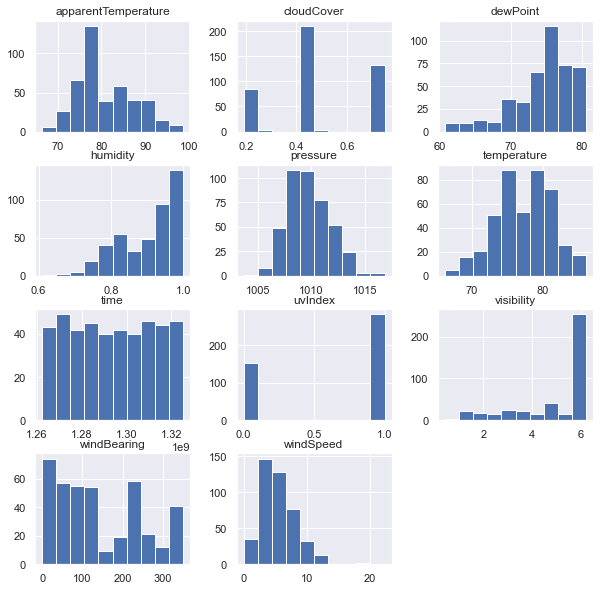

In [9]:
sns.set()
X_data_train.hist(figsize=(10,10))
plt.show()

In [10]:
train_dummy = X_data_train.copy()

### a. Humidity

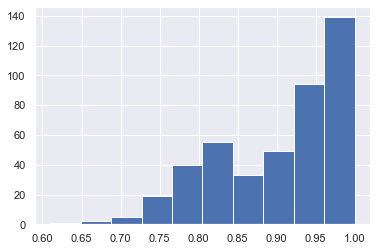

In [11]:
train_dummy.humidity.hist()

In [12]:
train_dummy.humidity.value_counts().sort_index(ascending=False)

1.00    137
0.98      1
0.97      1
0.94     94
0.92      1
0.89     48
0.88     31
0.87      1
0.85      1
0.84     28
0.83     26
0.82      1
0.79     20
0.78     18
0.77      2
0.74     16
0.73      3
0.70      2
0.69      3
0.65      2
0.61      1
Name: humidity, dtype: int64

In [13]:
# Dữ liệu có nhiễu, ta tiến hành gom các nhóm gần nhau và lấy trung bình
hum_mean_1 = train_dummy[train_dummy["humidity"] >= 0.97].describe().loc["mean", "humidity"]
print(hum_mean_1)
hum_mean_2 = train_dummy[(train_dummy["humidity"] >= 0.92) & (train_dummy["humidity"] <= 0.94)].describe().loc["mean", "humidity"]
print(hum_mean_2)
hum_mean_3 = train_dummy[(train_dummy["humidity"] >= 0.84) & (train_dummy["humidity"] <= 0.87)].describe().loc["mean", "humidity"]
print(hum_mean_3)
hum_mean_4 = train_dummy[(train_dummy["humidity"] >= 0.79) & (train_dummy["humidity"] < 0.83)].describe().loc["mean", "humidity"]
print(hum_mean_4)
hum_mean_5 = train_dummy[(train_dummy["humidity"] >= 0.61) & (train_dummy["humidity"] <= 0.77)].describe().loc["mean", "humidity"]
print(hum_mean_5)

0.9996402877697841
0.9397894736842101
0.8413333333333333
0.7914285714285713
0.7224137931034481


In [14]:
train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 1 if x >= 0.97 else x)
train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.94 if x >= 0.92 and x <= 0.94 else x)
train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.84 if x >= 0.84  and x <= 0.87 else x)
train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.79 if x >= 0.79 and x < 0.83 else x)
train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.72 if x <= 0.77 else x)

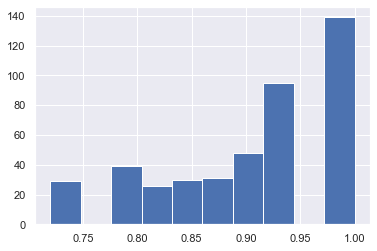

In [15]:
train_dummy.humidity.hist()

### b. Apparent Temperature

In [16]:
train_dummy.apparentTemperature.value_counts()

77.17    44
83.38    32
75.18    27
79.15    24
89.44    23
         ..
87.66     1
74.57     1
84.91     1
73.53     1
95.14     1
Name: apparentTemperature, Length: 72, dtype: int64

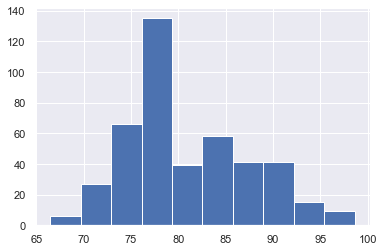

In [17]:
# Value count nhiều nên ta dựa vào hist
X_data_train.apparentTemperature.hist()

In [18]:
train_dummy[train_dummy["apparentTemperature"] >= 90].describe()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,visibility
count,3.200000e+01,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,29.000000,32.000000,32.0,30.000000
mean,1.280170e+09,83.417500,93.763125,77.930000,0.835938,1008.709375,7.577187,137.379310,0.396562,1.0,5.822067
std,1.252743e+07,1.201188,2.222844,1.570358,0.071881,1.319912,4.715654,67.526404,0.175859,0.0,0.999502
min,1.271894e+09,80.650000,91.010000,75.190000,0.720000,1006.600000,2.240000,30.000000,0.190000,1.0,1.244000
25%,1.273601e+09,82.480000,92.202500,76.990000,0.790000,1007.800000,3.460000,101.000000,0.190000,1.0,6.216000
50%,1.274270e+09,84.270000,92.930000,77.900000,0.840000,1008.500000,6.910000,110.000000,0.440000,1.0,6.216000
75%,1.275934e+09,84.270000,96.260000,78.810000,0.890000,1009.625000,9.495000,200.000000,0.440000,1.0,6.216000
max,1.307146e+09,86.060000,98.630000,80.580000,1.000000,1012.300000,22.380000,251.000000,0.750000,1.0,6.216000


In [19]:
tp_mean = train_dummy[train_dummy["apparentTemperature"] <= 72].describe().loc["mean", "apparentTemperature"]
print(tp_mean)
tp_mean = train_dummy[train_dummy["apparentTemperature"] >= 90].describe().loc["mean", "apparentTemperature"]
print(tp_mean)

70.1095652173913
93.763125


In [20]:
train_dummy.loc[:,"apparentTemperature"] = X_data_train["apparentTemperature"].apply(lambda x: 70.1 if x <= 72 else x)
train_dummy.loc[:,"apparentTemperature"] = train_dummy["apparentTemperature"].apply(lambda x: 93.76 if x >= 90 else x)

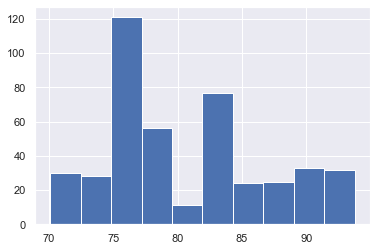

In [21]:
train_dummy.apparentTemperature.hist()

### c. Dew Point

In [22]:
train_dummy.dewPoint.value_counts().sort_index(ascending=False)

80.58      4
79.33      1
78.81     66
77.56      1
76.99     72
75.75      1
75.19    115
73.39     64
72.69      1
72.33      1
71.61     29
70.89      1
70.71      1
69.81     36
68.00     11
66.21     13
64.40     10
62.59      7
60.80      3
Name: dewPoint, dtype: int64

In [23]:
# Các giá trị này tự tính bằng tay
train_dummy.loc[:,"dewPoint"] = train_dummy["dewPoint"].apply(lambda x: 78.97 if x > 78 else x)
train_dummy.loc[:,"dewPoint"] = train_dummy["dewPoint"].apply(lambda x: 76.17 if x > 75.74 and x < 79.4 else x)
train_dummy.loc[:,"dewPoint"] = train_dummy["dewPoint"].apply(lambda x: 71.61 if x > 70.70 and x < 72.7 else x)
train_dummy.loc[:,"dewPoint"] = train_dummy["dewPoint"].apply(lambda x: 62.05 if x < 62.6 else x)

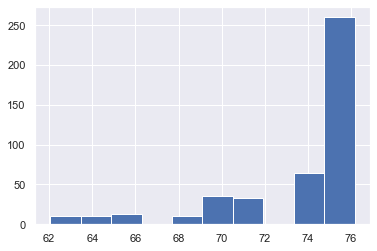

In [24]:
train_dummy.dewPoint.hist()

### d. Pressure

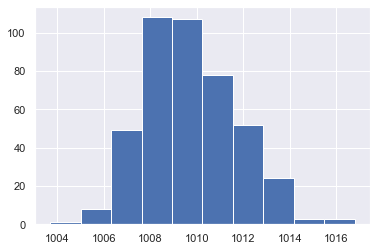

In [25]:
train_dummy.pressure.hist()

In [26]:
pre_mean = train_dummy[train_dummy["pressure"] < 1007].describe().loc["mean", "pressure"]
print(pre_mean)
pre_mean = train_dummy[train_dummy["pressure"] > 1013].describe().loc["mean", "pressure"]
print(pre_mean)

1006.4057142857145
1014.0454545454544


In [27]:
train_dummy.loc[:, "pressure"] = train_dummy["pressure"].apply(lambda x: 1006.4 if x < 1007 else x)
train_dummy.loc[:, "pressure"] = train_dummy["pressure"].apply(lambda x: 1014.04 if x > 1013 else x)

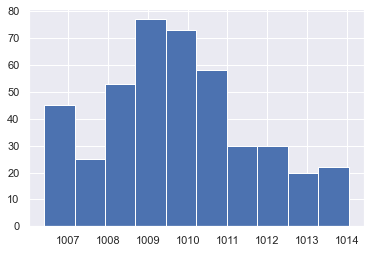

In [28]:
train_dummy.pressure.hist()

### e. Temperature

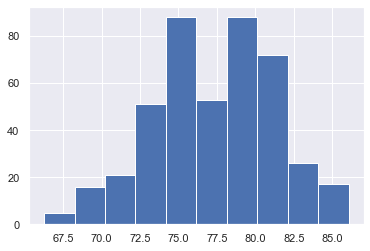

In [29]:
train_dummy.temperature.hist()

In [30]:
train_dummy.temperature.value_counts().sort_index(ascending=False)

86.06     1
84.27    16
83.92     1
82.48    24
82.44     1
81.38     1
80.65    71
79.57     1
79.22     1
78.88    85
78.66     1
77.06    53
75.81     2
75.25    86
73.45    50
73.21     1
71.67    21
69.87    15
68.43     1
68.06     2
66.27     3
Name: temperature, dtype: int64

In [31]:
tem_mean = train_dummy[train_dummy["temperature"] > 83.8].describe().loc["mean", "temperature"]
print(tem_mean)
tem_mean = train_dummy[(train_dummy["temperature"] > 81.2) & (train_dummy["temperature"] < 82.5)].describe().loc["mean", "temperature"]
print(tem_mean)
tem_mean = train_dummy[(train_dummy["temperature"] > 79.2) & (train_dummy["temperature"] < 80.7)].describe().loc["mean", "temperature"]
print(tem_mean)
tem_mean = train_dummy[(train_dummy["temperature"] > 75.8) & (train_dummy["temperature"] < 78.7)].describe().loc["mean", "temperature"]
print(tem_mean)
tem_mean = train_dummy[(train_dummy["temperature"] > 66.2) & (train_dummy["temperature"] < 73.3)].describe().loc["mean", "temperature"]
print(tem_mean)

84.35
82.43615384615386
80.61561643835614
77.0439285714286
70.45790697674418


In [32]:
train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 84.35 if x > 83.8 else x)
train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 82.43 if x > 81.2 and x < 82.5 else x)
train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 70.61 if x > 79.2 and x < 80.7 else x)
train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 77.04 if x > 75.8 and x < 78.7 else x)
train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 70.45 if x > 66.2 and x < 73.3 else x)

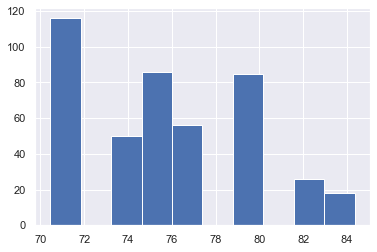

In [33]:
train_dummy.temperature.hist()

### f. Visibility

Thuộc tính này ta sẽ phân thành 2 lớp: `1` và `0`

In [34]:
train_dummy.visibility.value_counts()

6.216    254
4.974     42
3.730     21
3.108     20
5.591     15
4.346     14
1.244     13
1.862     13
2.488      7
2.422      4
1.555      4
2.048      3
2.796      2
1.120      2
2.609      2
1.429      2
2.175      2
1.617      1
1.801      1
0.434      1
3.097      1
0.931      1
2.982      1
0.621      1
Name: visibility, dtype: int64

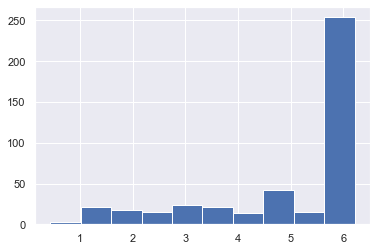

In [35]:
train_dummy.visibility.hist()

In [36]:
train_dummy.loc[:,"visibility"] = train_dummy["visibility"].apply(lambda x: 1 if x > 6 else 0)

### g. Wind Bearing

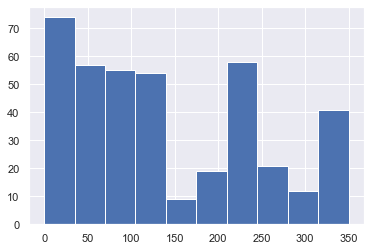

In [37]:
train_dummy.windBearing.hist()

In [38]:
train_dummy.windBearing.value_counts().sort_index(ascending=False)

350.0    15
341.0    10
330.0    12
320.0     4
311.0     6
300.0     1
290.0     4
281.0     1
270.0     1
260.0     4
251.0    16
240.0    11
230.0    14
221.0    15
210.0    18
200.0     9
191.0     6
180.0     4
170.0     3
150.0     2
140.0     4
132.0     1
131.0    15
120.0    15
110.0    23
101.0    15
90.0      8
80.0     13
79.0      1
71.0     18
60.0     18
50.0     21
41.0     18
30.0     19
20.0     12
11.0     18
0.0      25
Name: windBearing, dtype: int64

In [39]:
wb_mean_1 = train_dummy[(train_dummy["windBearing"] >= 79) & (train_dummy["windBearing"] < 90.1)].describe().loc["mean","windBearing"]
print(wb_mean_1)
wb_mean_2 = train_dummy[(train_dummy["windBearing"] >= 132) & (train_dummy["windBearing"] <= 200)].describe().loc["mean","windBearing"]
print(wb_mean_2)
wb_mean_3 = train_dummy[(train_dummy["windBearing"] >= 260) & (train_dummy["windBearing"] < 320.05)].describe().loc["mean","windBearing"]
print(wb_mean_3)

83.5909090909091
178.20689655172413
295.0952380952381


In [40]:
train_dummy.loc[:, "windBearing"] = train_dummy["windBearing"].apply(lambda x: 83.59 if x >= 79 and x < 90.1 else x)
train_dummy.loc[:, "windBearing"] = train_dummy["windBearing"].apply(lambda x: 178.2 if x >= 132 and x <= 200 else x)
train_dummy.loc[:, "windBearing"] = train_dummy["windBearing"].apply(lambda x: 295.1 if x >= 260 and x < 320.05 else x)

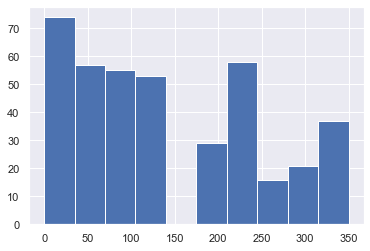

In [41]:
train_dummy.windBearing.hist()

### h. Wind Speed

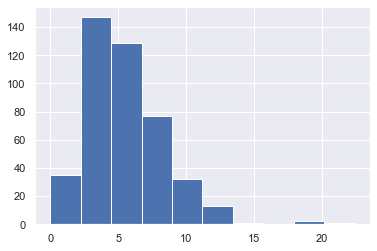

In [42]:
train_dummy.windSpeed.hist()

In [43]:
train_dummy.windSpeed.value_counts().sort_index(ascending=False)

22.38     1
20.12     2
15.65     1
12.67     6
11.51     7
10.35    11
9.21     19
8.96      2
8.33      1
8.05     22
6.91     47
6.72      7
5.74     51
4.61     65
4.48     13
3.46     69
2.69      1
2.29     68
2.24      9
1.16     20
1.11      1
0.00     14
Name: windSpeed, dtype: int64

In [44]:
ws_mean_1 = train_dummy[(train_dummy["windSpeed"] >= 0) & (train_dummy["windSpeed"] < 2.28)].describe().loc["mean","windSpeed"]
print(ws_mean_1)
ws_mean_2 = train_dummy[(train_dummy["windSpeed"] >= 2.28) & (train_dummy["windSpeed"] < 2.7)].describe().loc["mean","windSpeed"]
print(ws_mean_2)
ws_mean_3 = train_dummy[(train_dummy["windSpeed"] >= 4.4) & (train_dummy["windSpeed"] < 4.7)].describe().loc["mean","windSpeed"]
print(ws_mean_3)
ws_mean_4 = train_dummy[(train_dummy["windSpeed"] >= 6.7) & (train_dummy["windSpeed"] < 9)].describe().loc["mean","windSpeed"]
print(ws_mean_4)
ws_mean_5 = train_dummy[(train_dummy["windSpeed"] >= 9.2)].describe().loc["mean","windSpeed"]
print(ws_mean_5)

1.0106818181818182
2.2957971014492746
4.588333333333335
7.280506329113921
11.142553191489363


In [45]:
train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 1.01 if x < 2.28 else x)
train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 2.29 if x >= 2.28 and x < 2.7 else x)
train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 4.58 if x >= 4.4 and x < 4.7  else x)
train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 7.28 if x >= 6.7 and x < 9  else x)
train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 11.14 if x >= 9.2  else x)

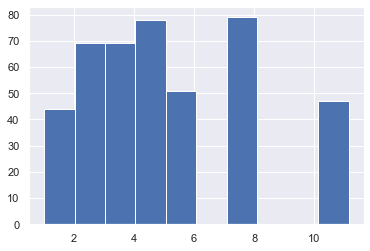

In [46]:
train_dummy.windSpeed.hist()

## 5. Các thí nghiệm mà nhóm thực hiện

### Tạo Preprocessing pipeline như phân tích ở trên

In [47]:
class Processing(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        train_dummy = X_df.copy()
        
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 1 if x >= 0.97 else x)
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.94 if x >= 0.92 and x <= 0.94 else x)
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.84 if x >= 0.84  and x <= 0.87 else x)
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.79 if x >= 0.79 and x < 0.83 else x)
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.72 if x <= 0.77 else x)
        
        train_dummy.loc[:,"apparentTemperature"] = X_data_train["apparentTemperature"].apply(lambda x: 70.1 if x <= 72 else x)
        train_dummy.loc[:,"apparentTemperature"] = train_dummy["apparentTemperature"].apply(lambda x: 93.76 if x >= 90 else x)
        
        train_dummy.loc[:,"dewPoint"] = train_dummy["dewPoint"].apply(lambda x: 78.97 if x > 78 else x)
        train_dummy.loc[:,"dewPoint"] = train_dummy["dewPoint"].apply(lambda x: 76.17 if x > 75.74 and x < 79.4 else x)
        train_dummy.loc[:,"dewPoint"] = train_dummy["dewPoint"].apply(lambda x: 71.61 if x > 70.70 and x < 72.7 else x)
        train_dummy.loc[:,"dewPoint"] = train_dummy["dewPoint"].apply(lambda x: 62.05 if x < 62.6 else x)
        
        train_dummy.loc[:, "pressure"] = train_dummy["pressure"].apply(lambda x: 1006.4 if x < 1007 else x)
        train_dummy.loc[:, "pressure"] = train_dummy["pressure"].apply(lambda x: 1014.04 if x > 1013 else x)

        train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 84.35 if x > 83.8 else x)
        train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 82.43 if x > 81.2 and x < 82.5 else x)
        train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 70.61 if x > 79.2 and x < 80.7 else x)
        train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 77.04 if x > 75.8 and x < 78.7 else x)
        train_dummy.loc[:,"temperature"] = train_dummy["temperature"].apply(lambda x: 70.45 if x > 66.2 and x < 73.3 else x)

        train_dummy.loc[:,"visibility"] = train_dummy["visibility"].apply(lambda x: 1 if x > 6 else 0)

        train_dummy.loc[:, "windBearing"] = train_dummy["windBearing"].apply(lambda x: 83.59 if x >= 79 and x < 90.1 else x)
        train_dummy.loc[:, "windBearing"] = train_dummy["windBearing"].apply(lambda x: 178.2 if x >= 132 and x <= 200 else x)
        train_dummy.loc[:, "windBearing"] = train_dummy["windBearing"].apply(lambda x: 295.1 if x >= 260 and x < 320.05 else x)

        train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 1.01 if x < 2.28 else x)
        train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 2.29 if x >= 2.28 and x < 2.7 else x)
        train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 4.58 if x >= 4.4 and x < 4.7  else x)
        train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 7.28 if x >= 6.7 and x < 9  else x)
        train_dummy.loc[:, "windSpeed"] = train_dummy["windSpeed"].apply(lambda x: 11.14 if x >= 9.2  else x)
        
        return train_dummy

### a. Phương pháp 1
Ở phương pháp này, nhóm sẽ tách cột `time` thành 2 cột là `day` và `month`. Nhóm sẽ bỏ cột `time`,`apparentTemperature` và `visibility`. Nhóm sẽ thử sử dụng `PCA` với `n_components` chạy từ `[1: số lượng cột]`

In [48]:
X_data_train.head()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,visibility
395,1296432000,68.43,69.06,64.40,0.87,1013.0,6.72,0.0,0.25,0.0,NaN
388,1295827200,69.87,71.25,69.81,1.00,1011.8,0.00,NaN,0.44,0.0,4.974
516,1306886400,80.65,86.25,75.19,0.84,1007.3,6.72,NaN,0.44,1.0,6.216
655,1318896000,77.06,79.15,76.99,1.00,1011.2,4.61,0.0,0.44,1.0,6.216
614,1315353600,80.65,87.67,76.99,0.89,1009.3,0.00,NaN,0.44,1.0,6.216


In [49]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_titles=1):
        self.num_top_titles = num_top_titles
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        tp = X_df.copy()
        time = pd.to_datetime(tp['time'], unit='s')
        day_sr = time.dt.day
        month_sr = time.dt.month
        tp.drop(labels=["visibility", "apparentTemperature", "time"], axis=1, inplace=True)
        tp['day'] = pd.Series(day_sr, index=tp.index)
        tp['month'] = pd.Series(month_sr, index=tp.index) 
        return tp

In [50]:
CAD = ColAdderDropper()
tp = CAD.transform(X_data_train)
tp.head()

,temperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,day,month
395,68.43,64.40,0.87,1013.0,6.72,0.0,0.25,0.0,31,1
388,69.87,69.81,1.00,1011.8,0.00,NaN,0.44,0.0,24,1
516,80.65,75.19,0.84,1007.3,6.72,NaN,0.44,1.0,1,6
655,77.06,76.99,1.00,1011.2,4.61,0.0,0.44,1.0,18,10
614,80.65,76.99,0.89,1009.3,0.00,NaN,0.44,1.0,7,9


In [51]:
num_col = ['temperature', 'dewPoint','humidity','pressure','windSpeed','windBearing','cloudCover','uvIndex','day','month']
num_col_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
num_col_trans = ColumnTransformer(
    [("num_imp", SimpleImputer(), num_col)]
)
method_1 = Pipeline(
    steps=[
        ('Preprocessing', Processing()),
        ('CAD', ColAdderDropper()),
        ('colTrans', num_col_trans),
        ('stdScalar', StandardScaler()),
        ('PCA', PCA(random_state=0)),
        ('linear', LinearRegression())
    ]
)

In [52]:
pca_component = list(range(1,len(num_col) + 1))
train_errs = []
val_errs = []
best_val_err = float('inf')
best_imp_method = None
best_PCA_component = None
for j in pca_component:
    method_1.set_params(PCA__n_components=j)
    model = method_1.fit(X_data_train, y_data_train)
    train_errs.append(mean_absolute_error(y_data_train, model.predict(X_data_train)))
    val_err = mean_absolute_error(y_data_val, model.predict(X_data_val))
    val_errs.append(val_err)
    if val_err < best_val_err:
        best_val_err = val_err
        best_PCA_component = j
"Finish"

'Finish'

In [53]:
print(best_val_err)
print(best_PCA_component)

0.05408005053366165
5


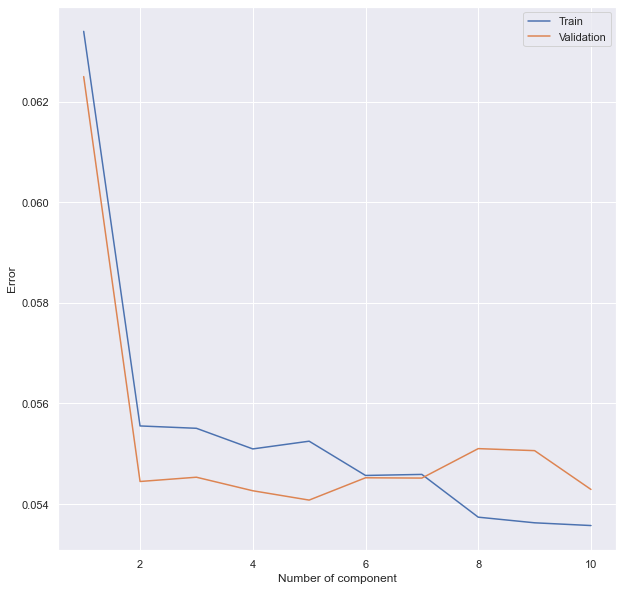

In [54]:
# Trực quan hóa kết quả
plt.figure(figsize=(10, 10))
plt.plot(pca_component, train_errs, label="Train")
plt.xlabel("Number of component")
plt.plot(pca_component, val_errs, label="Validation")
plt.ylabel("Error")
plt.xlabel("Number of component")
plt.legend()
plt.show()

**Nhận xét**  
Nhóm sử dụng độ lỗi `mean_absolute_error` và kết quả tốt nhất mô hình trả về là **0.054**. Theo nhóm đánh giá thì phương pháp 1 này không có độ chính xác cao vì theo như dữ liệu gốc ban đầu: `humidity` có `std` vào khoảng **0.08** mà độ lỗi của mô hình dự đoán có `std` là **0.054** (khá gần với **0.08**)  

### b. Phương pháp 2

Ở phương pháp này, nhóm sẽ giữ nguyên toàn bộ các đặc trưng ban đầu, không thêm hay xóa bất kỳ cột nào. Quy trình làm vẫn tương tự như phương pháp 1 để xem kết quả có cải thiện hơn hay không

In [55]:
X_data_train.head()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,visibility
395,1296432000,68.43,69.06,64.40,0.87,1013.0,6.72,0.0,0.25,0.0,NaN
388,1295827200,69.87,71.25,69.81,1.00,1011.8,0.00,NaN,0.44,0.0,4.974
516,1306886400,80.65,86.25,75.19,0.84,1007.3,6.72,NaN,0.44,1.0,6.216
655,1318896000,77.06,79.15,76.99,1.00,1011.2,4.61,0.0,0.44,1.0,6.216
614,1315353600,80.65,87.67,76.99,0.89,1009.3,0.00,NaN,0.44,1.0,6.216


In [56]:
num_col = ['time', 'temperature', 'apparentTemperature', 'dewPoint',
           'humidity','pressure','windSpeed','windBearing','cloudCover',
           'uvIndex','visibility']
num_col_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
num_col_trans = ColumnTransformer(
    [("num_imp", SimpleImputer(), num_col)]
)
method_2 = Pipeline(
    steps=[
        ('Preprocessing', Processing()),
        ('colTrans', num_col_trans),
        ('stdScalar', StandardScaler()),
        ('PCA', PCA(random_state=0)),
        ('linear', LinearRegression())
    ]
)

In [57]:
pca_component = list(range(1,len(num_col) + 1))
train_errs = []
val_errs = []
best_val_err = float('inf')
best_PCA_component = None
for j in pca_component:
    method_2.set_params(PCA__n_components=j)
    model = method_2.fit(X_data_train, y_data_train)
    train_errs.append(mean_absolute_error(y_data_train, model.predict(X_data_train)))
    val_err = mean_absolute_error(y_data_val, model.predict(X_data_val))
    val_errs.append(val_err)
    if val_err < best_val_err:
        best_val_err = val_err
        best_PCA_component = j + 1
"Finish"

'Finish'

In [58]:
print(best_val_err)
print(best_PCA_component)

0.055554982840343735
7


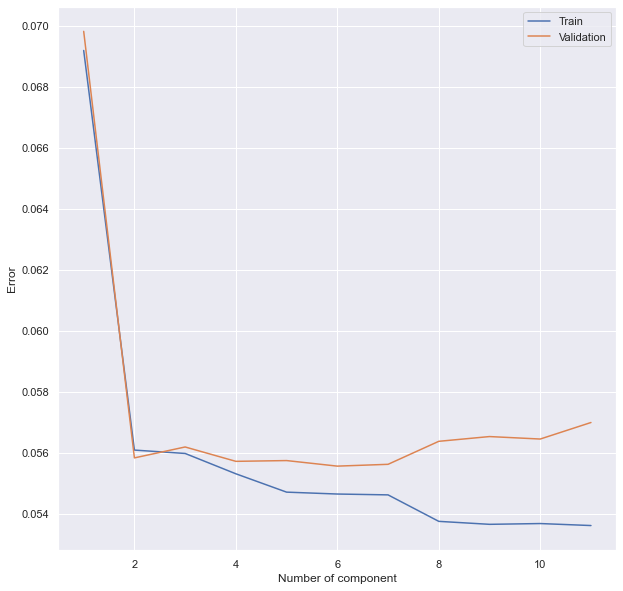

In [59]:
# Trực quan hóa kết quả
plt.figure(figsize=(10, 10))
plt.plot(pca_component, train_errs, label="Train")
plt.xlabel("Number of component")
plt.plot(pca_component, val_errs, label="Validation")
plt.ylabel("Error")
plt.xlabel("Number of component")
plt.legend()
plt.show()

**Nhận xét**

Kết quả của phương pháp này nhỏ hơn phương pháp đầu tiên, độ lỗi trên tập validation la **0.055**

### c. Phương pháp 3
Ở phương pháp này, nhóm sẽ lựa chọn đặc tính bằng phương pháp `Pearson's Correlation`

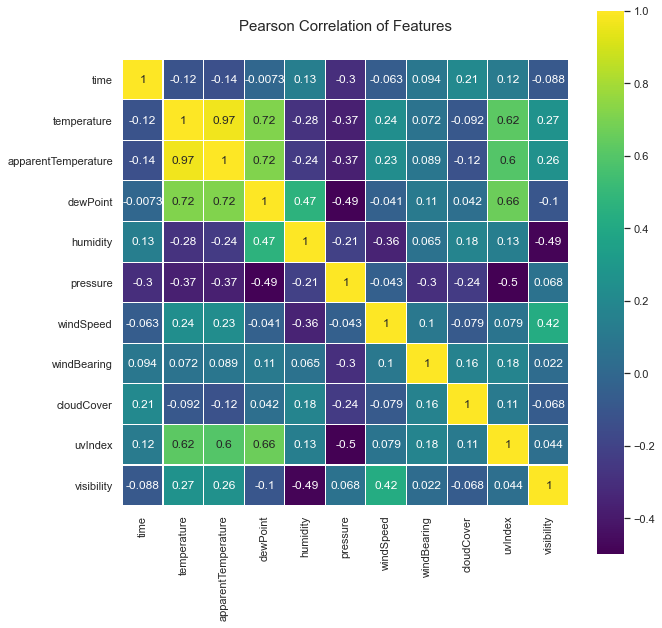

In [60]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_df.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

- 1 có nghĩa là chúng có tương quan cao
- 0 có nghĩa là không có tương quan
- -1 có nghĩa là có một mối tương quan nghịch như là một tỷ lệ nghịch.
- Do đó chúng ta sẽ bỏ đi những đặc trưng có mối tương quan thấp với humidity

In [61]:
class ColDropperPearsonCorrelation(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        tp = X_df.copy()
        tp.drop(labels=["time", "windBearing", "cloudCover", "uvIndex"], axis=1, inplace=True)
        return tp

In [62]:
CD = ColDropperPearsonCorrelation()
tp = CD.transform(X_data_train)
tp.head()

,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,visibility
395,68.43,69.06,64.40,0.87,1013.0,6.72,NaN
388,69.87,71.25,69.81,1.00,1011.8,0.00,4.974
516,80.65,86.25,75.19,0.84,1007.3,6.72,6.216
655,77.06,79.15,76.99,1.00,1011.2,4.61,6.216
614,80.65,87.67,76.99,0.89,1009.3,0.00,6.216


In [63]:
num_col = ['temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'visibility']
num_col_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
num_col_trans = ColumnTransformer(
    [("num_imp", SimpleImputer(), num_col)]
)
method_3 = Pipeline(
    steps=[
        ('Preprocessing', Processing()),
        ('CDPC', ColDropperPearsonCorrelation()),
        ('colTrans', num_col_trans),
        ('stdScalar', StandardScaler()),
        ('linear', LinearRegression())
    ]
)

In [64]:
model = method_3.fit(X_data_train, y_data_train)
train_err = mean_absolute_error(y_data_train, model.predict(X_data_train))
val_err = mean_absolute_error(y_data_val, model.predict(X_data_val))
"Finish"

'Finish'

In [65]:
print(train_err)
print(val_err)

0.05511815692514897
0.05644854348722511


**Nhận xét**

Độ lỗi trên tập validation của phương pháp này khá gần với phương pháp số 2 là **0.056**

### d. Phương pháp 4
Ở phương pháp này, nhóm sẽ lựa chọn đặc tính bằng phương pháp `SelectKBest`

In [66]:
temp_df = data_df.copy()
temp_df = temp_df[['time', 'temperature', 'apparentTemperature', 'dewPoint', 'pressure', 
                   'windSpeed', 'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'humidity']]
temp_df = temp_df.fillna(temp_df.mean())
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 730 non-null    int64  
 1   temperature          730 non-null    float64
 2   apparentTemperature  730 non-null    float64
 3   dewPoint             730 non-null    float64
 4   pressure             730 non-null    float64
 5   windSpeed            730 non-null    float64
 6   windBearing          730 non-null    float64
 7   cloudCover           730 non-null    float64
 8   uvIndex              730 non-null    float64
 9   visibility           730 non-null    float64
 10  humidity             730 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 62.8 KB


In [67]:
array = temp_df.values
X = array[:,0:10]
Y = array[:,10]
Y = Y.astype('int')

test = SelectKBest(f_regression, k=5)
fit = test.fit(X,Y)
np.set_printoptions(precision=3) 

print(fit.scores_)
print() 

for i in range(len(temp_df.columns) - 1):
    print(str(temp_df.columns[i]) + ": "  + str(fit.scores_[i]))

[3.034e+00 5.845e+01 6.084e+01 5.038e+01 1.066e+01 5.440e+01 2.116e-01
 2.201e+01 6.355e+00 2.342e+02]

time: 3.033550878714981
temperature: 58.45496004407256
apparentTemperature: 60.83930295184548
dewPoint: 50.375562168460306
pressure: 10.656494314274688
windSpeed: 54.40052241589734
windBearing: 0.2116486554207041
cloudCover: 22.006415065482788
uvIndex: 6.354606736242444
visibility: 234.17316778418058


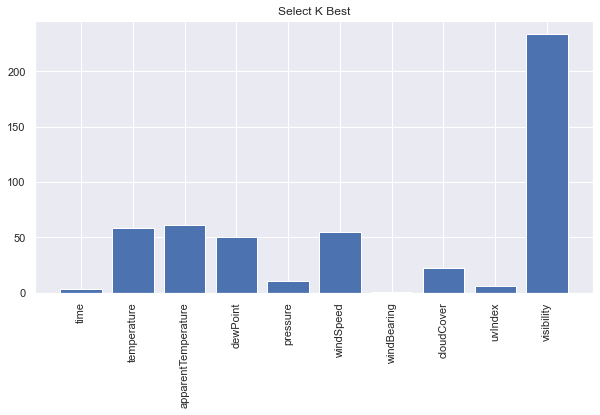

In [68]:
columns = temp_df[:-1]
features_selection = fit.scores_
plt.figure(figsize=(10,5))
plt.title("Select K Best")
y_pos = np.arange(len(temp_df.columns)-1)
plt.bar(y_pos, features_selection, align='center')
plt.xticks(y_pos, columns, rotation=90)
plt.show()

In [69]:
class ColDropperK(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        tp = X_df.copy()
        tp.drop(labels=["time", "pressure", "cloudCover", "uvIndex", "windBearing"], axis=1, inplace=True)
        return tp

In [70]:
CD = ColDropperK()
tp = CD.transform(X_data_train)
tp.head()

,temperature,apparentTemperature,dewPoint,humidity,windSpeed,visibility
395,68.43,69.06,64.40,0.87,6.72,NaN
388,69.87,71.25,69.81,1.00,0.00,4.974
516,80.65,86.25,75.19,0.84,6.72,6.216
655,77.06,79.15,76.99,1.00,4.61,6.216
614,80.65,87.67,76.99,0.89,0.00,6.216


In [71]:
num_col = ['temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed', 'visibility']
num_col_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
num_col_trans = ColumnTransformer(
    [("num_imp", SimpleImputer(), num_col)]
)
method_4 = Pipeline(
    steps=[
        ('Preprocessing', Processing()),
        ('CDK', ColDropperK()),
        ('colTrans', num_col_trans),
        ('stdScalar', StandardScaler()),
        ('linear', LinearRegression())
    ]
)

In [72]:
model = method_4.fit(X_data_train, y_data_train)
train_err = mean_absolute_error(y_data_train, model.predict(X_data_train))
val_err = mean_absolute_error(y_data_val, model.predict(X_data_val))
"Finish"

'Finish'

In [73]:
print(train_err)
print(val_err)

0.05546944950527753
0.05699691235000314


**Nhận xét**

Độ lỗi của phương pháp này hiện tại là lớn nhất **0.056**

### e. Phương pháp 5
Ở phương pháp này, nhóm sẽ lựa chọn đặc tính bằng phương pháp `Support Vector Regression`

In [74]:
num_col = ['time', 'temperature', 'apparentTemperature', 'dewPoint',
           'humidity','pressure','windSpeed','windBearing','cloudCover',
           'uvIndex','visibility']
num_col_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
num_col_trans = ColumnTransformer(
    [("num_imp", SimpleImputer(), num_col)]
)
method_5 = Pipeline(
    steps=[
        ('Preprocessing', Processing()),
        ('colTrans', num_col_trans),
        ('stdScalar', StandardScaler()),
        ('PCA', PCA(random_state=0)),
        ('svn', SVR())
    ]
)

In [75]:
pca_component = list(range(1,len(num_col) + 1))
train_errs = []
val_errs = []
best_val_err = float('inf')
best_PCA_component = None
for j in pca_component:
    method_5.set_params(PCA__n_components=j)
    model = method_5.fit(X_data_train, y_data_train)
    train_errs.append(mean_absolute_error(y_data_train, model.predict(X_data_train)))
    val_err = mean_absolute_error(y_data_val, model.predict(X_data_val))
    val_errs.append(val_err)
    if val_err < best_val_err:
        best_val_err = val_err
        best_PCA_component = j
"Finish"

'Finish'

In [76]:
print(best_val_err)
print(best_PCA_component)

0.06328107985251424
11


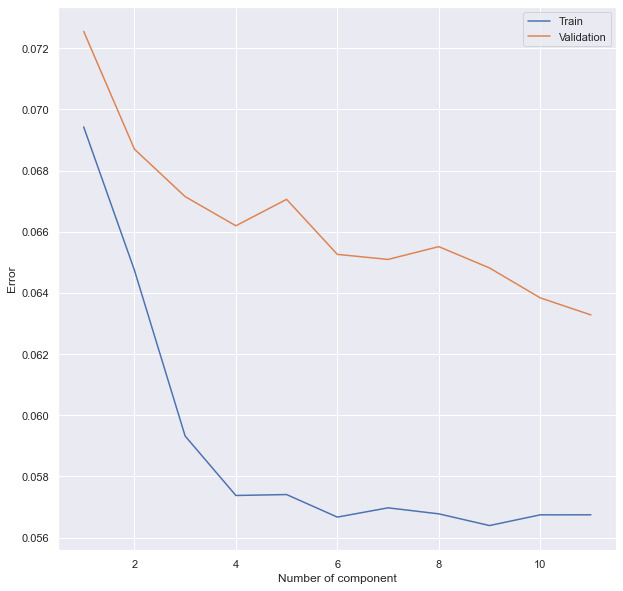

In [77]:
# Trực quan hóa kết quả
plt.figure(figsize=(10, 10))
plt.plot(pca_component, train_errs, label="Train")
plt.xlabel("Number of component")
plt.plot(pca_component, val_errs, label="Validation")
plt.ylabel("Error")
plt.xlabel("Number of component")
plt.legend()
plt.show()

**Nhận xét**

Phương pháp này có độ lỗi trên tập validation là **0.063**

### f. Phương pháp 6
Ở phương pháp này, nhóm sẽ lựa chọn mô hình `Neural Network`

In [78]:
X_data_train.head()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,visibility
395,1296432000,68.43,69.06,64.40,0.87,1013.0,6.72,0.0,0.25,0.0,NaN
388,1295827200,69.87,71.25,69.81,1.00,1011.8,0.00,NaN,0.44,0.0,4.974
516,1306886400,80.65,86.25,75.19,0.84,1007.3,6.72,NaN,0.44,1.0,6.216
655,1318896000,77.06,79.15,76.99,1.00,1011.2,4.61,0.0,0.44,1.0,6.216
614,1315353600,80.65,87.67,76.99,0.89,1009.3,0.00,NaN,0.44,1.0,6.216


In [79]:
num_col = ['time', 'temperature', 'apparentTemperature', 'dewPoint','humidity','pressure',
           'windSpeed','windBearing','cloudCover','uvIndex','visibility']
num_col_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
Preprocessing = Processing()
num_col_trans = ColumnTransformer(
    [("num_imp", SimpleImputer(), num_col)]
)

In [80]:
scaler_model = StandardScaler()
neural_net_model = MLPRegressor(hidden_layer_sizes=20, activation="logistic",max_iter=1000, random_state=0)
method_6 = make_pipeline(Preprocessing, num_col_trans, scaler_model, neural_net_model)

In [81]:
train_errs = []
val_errs = []
alphas = [0.01, 0.1, 1, 10, 100, 1000]
hLayer = [1, 5, 10, 15, 20, 100]
best_val_err = float('Inf')
best_alpha = None
best_hlayer = None
for alpha in alphas:
    for h in hLayer:
        method_6.set_params(mlpregressor__alpha=alpha, mlpregressor__hidden_layer_sizes=h)
        model = method_6.fit(X_data_train, y_data_train)
        train_errs.append(mean_absolute_error(y_data_train, model.predict(X_data_train)))
        val_err = mean_absolute_error(y_data_val, model.predict(X_data_val))
        val_errs.append(val_err)
        if val_err < best_val_err:
            best_val_err = val_err
            best_alpha = alpha
            best_hlayer = h
'Finish!'

'Finish!'

In [82]:
print(best_val_err)
print(best_alpha)
print(best_hlayer)

0.056768929056698704
1
100


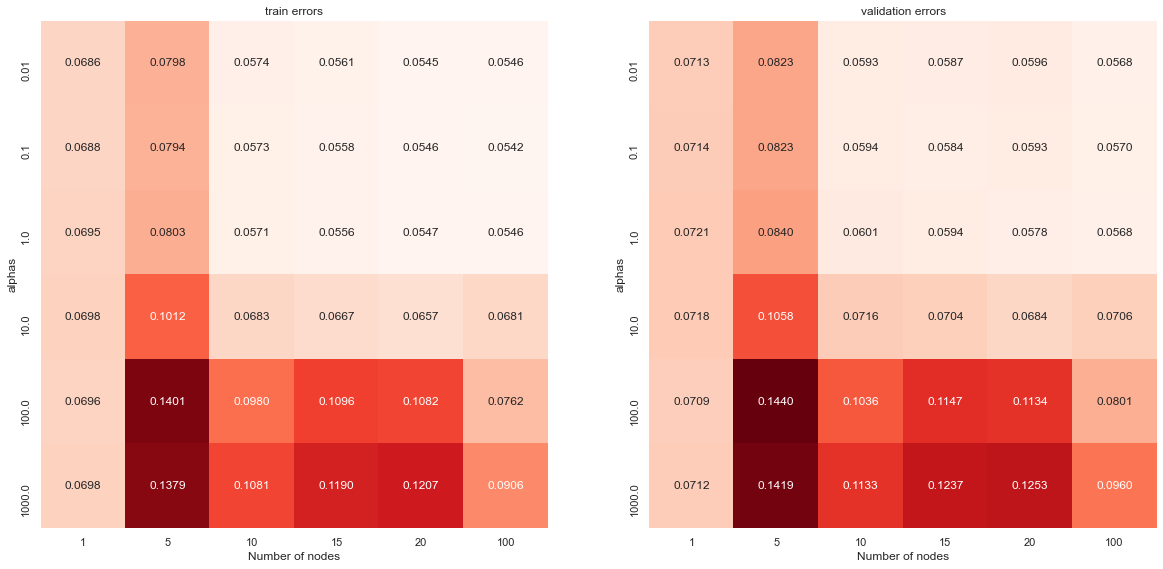

In [83]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=hLayer)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=hLayer)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.4f', cmap='Reds')
plt.title('train errors'); plt.xlabel('Number of nodes'); plt.ylabel('alphas')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.4f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('Number of nodes'); plt.ylabel('alphas');

**Nhận xét**

Kết quả của mô hình `MLPRegressor` cũng không tốt hơn các phương pháp mà nhóm đã làm. Độ lỗi là **0.056**

### g. Phương pháp 7
Nhóm nghĩ dùng 1 ngày để dự đoán ngày hôm sau sẽ không đủ nên sẽ dùng `k` ngày. Ở đây nhóm thử trường hợp `k = 14` và nhóm chỉ lấy cột `humidity` của `k` ngày này còn các cột khác nhóm sẽ bỏ. Bên dưới nhóm sẽ duyệt lần lượt số ngày trước ngày cần dự đoán

In [84]:
class FinalPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        train_dummy = X_df.copy()
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 1 if x >= 0.97 else x)
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.94 if x >= 0.92 and x <= 0.94 else x)
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.84 if x >= 0.84  and x <= 0.87 else x)
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.79 if x >= 0.79 and x < 0.83 else x)
        train_dummy.loc[:,"humidity"] = train_dummy["humidity"].apply(lambda x: 0.72 if x <= 0.77 else x)
        return train_dummy

In [85]:
k = 14
for i in range(k):
    title = "day_" + str(i + 1)
    humidity = data_df.humidity.copy().to_list()
    N = len(humidity)
    tp = [0] * (i + 1) + humidity[: N - i - 1]
    data_df[title] = pd.Series(tp, index=data_df.index)

In [86]:
data_df.head()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,...,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14
0,1262304000,73.45,75.07,72.69,0.97,1010.3,6.72,71.0,0.50,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1262390400,71.67,72.95,69.81,0.94,1011.0,2.29,41.0,0.44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1262476800,75.25,76.89,73.39,0.94,1011.6,1.16,30.0,0.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1262563200,75.25,76.64,71.61,0.88,1010.9,3.46,71.0,0.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1262649600,75.25,76.89,73.39,0.94,1010.1,6.91,120.0,0.44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
new_df = data_df.drop(index=list(range(k)))
new_df.head()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,...,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14
14,1263513600,66.27,67.29,66.21,1.00,1016.1,3.46,320.0,0.44,0.0,...,0.88,1.00,1.00,0.94,0.88,0.94,0.88,0.94,0.94,0.97
15,1263600000,69.87,70.21,62.59,0.78,1015.6,5.74,11.0,0.75,0.0,...,0.94,0.88,1.00,1.00,0.94,0.88,0.94,0.88,0.94,0.94
16,1263686400,69.87,70.45,64.40,0.83,1015.6,6.72,NaN,0.44,0.0,...,1.00,0.94,0.88,1.00,1.00,0.94,0.88,0.94,0.88,0.94
17,1263772800,69.87,70.70,66.21,0.88,1014.1,2.29,300.0,0.75,0.0,...,1.00,1.00,0.94,0.88,1.00,1.00,0.94,0.88,0.94,0.88
18,1263859200,73.45,74.65,69.81,0.88,1012.0,4.61,350.0,0.75,0.0,...,0.94,1.00,1.00,0.94,0.88,1.00,1.00,0.94,0.88,0.94


In [88]:
y_data_7 = new_df["humidity"].copy()
y_data_7 = y_data_7[1:]
y_data_7.head()

15    0.78
16    0.83
17    0.88
18    0.88
19    1.00
Name: humidity, dtype: float64

In [89]:
new_df = new_df.drop(index=729)
new_df.head()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,...,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14
14,1263513600,66.27,67.29,66.21,1.00,1016.1,3.46,320.0,0.44,0.0,...,0.88,1.00,1.00,0.94,0.88,0.94,0.88,0.94,0.94,0.97
15,1263600000,69.87,70.21,62.59,0.78,1015.6,5.74,11.0,0.75,0.0,...,0.94,0.88,1.00,1.00,0.94,0.88,0.94,0.88,0.94,0.94
16,1263686400,69.87,70.45,64.40,0.83,1015.6,6.72,NaN,0.44,0.0,...,1.00,0.94,0.88,1.00,1.00,0.94,0.88,0.94,0.88,0.94
17,1263772800,69.87,70.70,66.21,0.88,1014.1,2.29,300.0,0.75,0.0,...,1.00,1.00,0.94,0.88,1.00,1.00,0.94,0.88,0.94,0.88
18,1263859200,73.45,74.65,69.81,0.88,1012.0,4.61,350.0,0.75,0.0,...,0.94,1.00,1.00,0.94,0.88,1.00,1.00,0.94,0.88,0.94


In [90]:
y_data_7.head()

15    0.78
16    0.83
17    0.88
18    0.88
19    1.00
Name: humidity, dtype: float64

In [91]:
X_data_temp, X_data_val_7, y_data_temp, y_data_val_7 = train_test_split(new_df, y_data_7, test_size=0.2, random_state=0)
X_data_train_7, X_data_test_7, y_data_train_7, y_data_test_7= train_test_split(X_data_temp, y_data_temp, test_size=0.25, random_state=0)
print(len(X_data_train_7), len(y_data_train_7))
print(len(X_data_val_7), len(y_data_val_7))
print(len(X_data_test_7), len(y_data_test_7))

429 429
143 143
143 143


In [92]:
class CAD(BaseEstimator, TransformerMixin):
    def __init__(self, numDay=7):
        self.numDay = numDay
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        tp = X_df.copy()
        days = ["humidity"]
        for i in range(self.numDay):
            days.append('day_' + str(i + 1))
        tp = tp[days]
        return tp

In [93]:
cad = CAD(9)
cad.transform(X_data_train_7).head()

,humidity,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9
172,0.89,1.00,1.00,0.89,1.00,0.89,1.00,1.00,0.79,0.94
232,1.00,1.00,0.94,0.94,1.00,1.00,1.00,1.00,1.00,1.00
314,1.00,0.94,1.00,1.00,1.00,1.00,0.94,0.88,1.00,1.00
508,0.84,0.84,0.89,0.94,0.89,0.89,1.00,1.00,0.94,0.89
113,0.74,0.84,0.79,0.89,0.79,0.79,0.79,0.74,0.79,0.74


In [94]:
y_data_train_7.head()

173    0.94
233    1.00
315    1.00
509    0.89
114    0.74
Name: humidity, dtype: float64

In [95]:
method_7 = Pipeline(
    steps=[
        ('pre', FinalPreprocessing()),
        ('CAD', CAD()),
        ('stdScalar', StandardScaler()),
        ('nnm', MLPRegressor(hidden_layer_sizes=20, activation="logistic",max_iter=1000, random_state=0))
    ]
)

In [96]:
numDays = list(range(1, k + 1))
hLayer = [1, 5, 10, 15, 20, 100]
train_errs = []
val_errs = []
best_val_err = float('Inf')
best_day = None
best_hLayer = None
for i in numDays:
    for h in hLayer:
        method_7.set_params(CAD__numDay=i, nnm__hidden_layer_sizes=h)
        model = method_7.fit(X_data_train_7, y_data_train_7)
        train_errs.append(mean_absolute_error(y_data_train_7, model.predict(X_data_train_7)))
        val_err = mean_absolute_error(y_data_val_7, model.predict(X_data_val_7))
        val_errs.append(val_err)
        if val_err < best_val_err:
            best_val_err = val_err
            best_day = i
            best_hLayer = h
"Finish"

'Finish'

In [97]:
print(best_val_err)
print(best_day)
print(best_hLayer)

0.04482647930057598
4
100


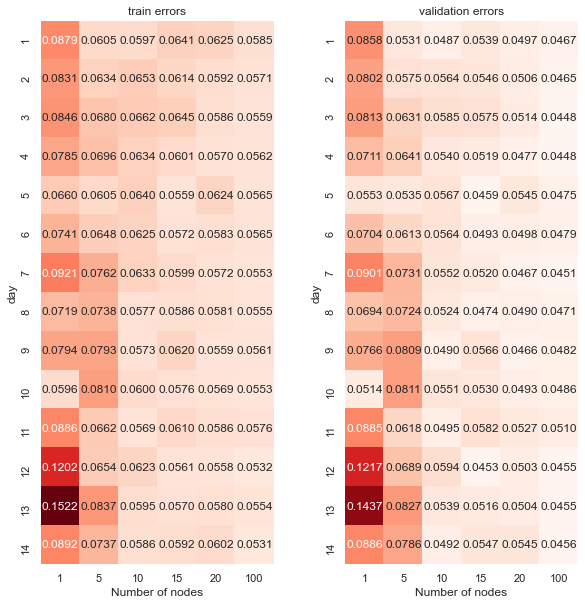

In [98]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(numDays), -1),
                             index=numDays, columns=hLayer)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(numDays), -1), 
                           index=numDays, columns=hLayer)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.4f', cmap='Reds')
plt.title('train errors'); plt.xlabel('Number of nodes'); plt.ylabel('day')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.4f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('Number of nodes'); plt.ylabel('day');

**Nhận xét**  
Với phương pháp này thì độ lỗi trên tập validation giảm so với các phương pháp trước **0.0448**

## 6. Tổng kết

Nhóm sẽ chọn phương pháp số 7 để dự đoán. Nhóm tiến hành train lại trên tập `X_data_train_7` và `X_data_val_7`, chính là tập `X_data_temp`. Sau đó, nhóm sẽ tiến hành chấm điểm trên tập `X_data_val_7`

In [99]:
method_7

Pipeline(steps=[('pre', FinalPreprocessing()), ('CAD', CAD(numDay=14)),
                ('stdScalar', StandardScaler()),
                ('nnm',
                 MLPRegressor(activation='logistic', hidden_layer_sizes=100,
                              max_iter=1000, random_state=0))])

In [100]:
X_data_temp

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,...,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14
324,1290297600,73.45,75.18,73.39,1.00,1008.1,2.29,320.0,0.44,0.0,...,1.00,1.00,0.94,0.94,1.00,1.00,0.94,1.00,1.00,1.00
556,1310342400,78.88,82.55,75.19,0.89,1005.7,2.24,NaN,0.75,1.0,...,1.00,0.94,1.00,0.89,1.00,1.00,0.94,0.89,0.89,0.94
31,1264982400,71.67,73.23,71.61,1.00,1013.7,2.29,140.0,0.44,0.0,...,1.00,1.00,1.00,1.00,0.94,1.00,1.00,1.00,0.88,0.88
280,1286496000,77.06,78.88,75.19,0.94,1009.1,2.29,0.0,0.75,1.0,...,1.00,1.00,1.00,1.00,1.00,0.89,1.00,1.00,0.94,0.94
332,1290988800,75.25,77.17,75.19,1.00,1009.0,2.29,60.0,0.44,0.0,...,0.94,1.00,1.00,1.00,1.00,1.00,1.00,0.94,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,1324598400,75.25,76.64,71.61,0.88,1009.6,4.61,30.0,0.44,0.0,...,0.83,0.88,1.00,1.00,0.94,0.78,0.83,0.65,0.88,1.00
206,1280102400,75.25,77.17,75.19,1.00,1005.4,1.16,221.0,0.75,1.0,...,0.94,1.00,1.00,0.94,1.00,0.89,1.00,1.00,0.94,0.94
643,1317859200,77.06,79.15,76.99,1.00,1010.4,2.29,50.0,0.75,1.0,...,1.00,1.00,0.94,1.00,1.00,1.00,0.89,1.00,1.00,0.94
573,1311811200,75.25,77.17,75.19,1.00,1006.4,1.16,251.0,0.44,1.0,...,0.79,0.94,0.89,0.89,0.89,0.94,0.79,0.84,0.88,0.94


In [101]:
y_data_temp.head()

325    1.00
557    0.84
32     0.94
281    1.00
333    1.00
Name: humidity, dtype: float64

In [102]:
method_7.set_params(CAD__numDay=best_day, nnm__hidden_layer_sizes=best_hLayer)
FinalModel = method_7.fit(X_data_temp, y_data_temp)
print("Độ lỗi r2_score là: ", method_7.score(X_data_temp, y_data_temp))

Độ lỗi r2_score là:  0.36182313174762537


In [103]:
X_data_val_7.head()

,time,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,cloudCover,uvIndex,...,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14
353,1292803200,73.45,74.91,71.61,0.94,1010.1,0.00,NaN,0.44,0.0,...,1.00,0.94,0.94,0.95,1.00,1.00,0.78,0.83,0.94,1.00
156,1275782400,84.27,94.29,76.99,0.79,1008.3,4.48,NaN,0.19,1.0,...,0.84,0.84,0.79,0.94,0.79,0.84,0.84,0.85,0.84,0.86
257,1284508800,73.45,75.18,73.39,1.00,1009.5,2.29,60.0,0.44,1.0,...,1.00,0.89,1.00,1.00,0.89,0.89,1.00,0.94,0.94,0.94
250,1283904000,78.88,83.38,78.81,1.00,1008.4,3.46,350.0,0.44,1.0,...,0.94,0.94,0.94,1.00,1.00,1.00,1.00,1.00,0.94,1.00
727,1325116800,71.67,72.44,66.21,0.83,1012.8,2.29,11.0,0.44,0.0,...,0.78,0.88,1.00,0.94,0.83,0.83,0.83,0.88,1.00,1.00


In [104]:
y_data_val_7.head()

354    0.94
157    0.89
258    1.00
251    0.89
728    0.88
Name: humidity, dtype: float64

In [107]:
y_pred_val = FinalModel.predict(X_data_val_7)
print("Độ lỗi MAE trên tập Validation là: ", mean_absolute_error(y_pred_val, y_data_val_7))

Độ lỗi MAE trên tập Validation là:  0.0446785968025016


Text(0.5, 0, 'Time')

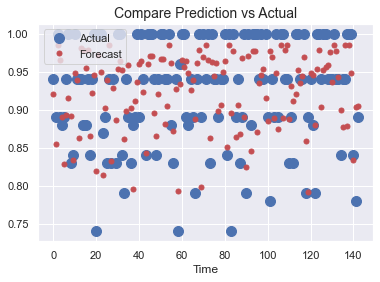

In [106]:
plt.title("Compare Prediction vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_data_val_7)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred_val)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time")